In [1]:
# import required libraries
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

## 1. Load the Dataset

In [2]:
df = pd.read_csv("../data/smart_phone_surface_plastic_manufacture.csv")
# Display the first few rows of the dataset
df.head()

,Unnamed: 0,Production Run ID,Date,Temperature (°C),Pressure (Pa),Cooling Rate (°C/min),Machine Speed (RPM),Raw Material Quality (Score),Humidity (%),Ambient Temperature (°C),Maintenance (Days Since),Operator Shift,Batch Size (Units),Energy Consumption (kWh),Production Line,Production Output (Units),Defect Rate (%),Downtime (Minutes)
0,0,1,2023-01-01 00:00:00,199.587579,5187.346865,4.197020,1467.853751,77.249494,54.419352,22.916290,36.0,Night,104.0,50.311084,Line 1,963,0.925473,25.0
1,1,2,2023-01-01 01:00:00,224.800678,5214.943372,4.561051,1522.273687,76.700630,56.171668,22.872015,28.0,Night,NaN,46.691092,Line 1,1043,2.071200,37.0
2,2,3,2023-01-01 02:00:00,224.027162,4856.441687,4.936852,1423.536278,80.541510,49.527377,29.149278,25.0,Day,97.0,41.040091,Line 1,969,2.387125,30.0
3,3,4,2023-01-01 03:00:00,204.448237,5105.486001,5.156183,1553.104489,85.953493,51.710811,27.805151,24.0,Day,NaN,49.862947,Line 3,956,1.419953,26.0
4,4,5,2023-01-01 04:00:00,200.254929,4831.980194,5.514289,1467.818958,NaN,56.596582,27.507715,37.0,Day,112.0,47.542142,Line 3,1012,NaN,28.0


In [3]:
df.shape

(4161, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    4161 non-null   int64  
 1   Production Run ID             4161 non-null   int64  
 2   Date                          4161 non-null   object 
 3   Temperature (°C)              3953 non-null   float64
 4   Pressure (Pa)                 3953 non-null   float64
 5   Cooling Rate (°C/min)         3953 non-null   float64
 6   Machine Speed (RPM)           3953 non-null   float64
 7   Raw Material Quality (Score)  3953 non-null   float64
 8   Humidity (%)                  3953 non-null   float64
 9   Ambient Temperature (°C)      3953 non-null   float64
 10  Maintenance (Days Since)      3953 non-null   float64
 11  Operator Shift                4161 non-null   object 
 12  Batch Size (Units)            3953 non-null   float64
 13  Ene

In [5]:
# Drop Unnecessary Columns
df = df.drop(columns=["Unnamed: 0", "Production Run ID", "Date"])
df.head()

,Temperature (°C),Pressure (Pa),Cooling Rate (°C/min),Machine Speed (RPM),Raw Material Quality (Score),Humidity (%),Ambient Temperature (°C),Maintenance (Days Since),Operator Shift,Batch Size (Units),Energy Consumption (kWh),Production Line,Production Output (Units),Defect Rate (%),Downtime (Minutes)
0,199.587579,5187.346865,4.197020,1467.853751,77.249494,54.419352,22.916290,36.0,Night,104.0,50.311084,Line 1,963,0.925473,25.0
1,224.800678,5214.943372,4.561051,1522.273687,76.700630,56.171668,22.872015,28.0,Night,NaN,46.691092,Line 1,1043,2.071200,37.0
2,224.027162,4856.441687,4.936852,1423.536278,80.541510,49.527377,29.149278,25.0,Day,97.0,41.040091,Line 1,969,2.387125,30.0
3,204.448237,5105.486001,5.156183,1553.104489,85.953493,51.710811,27.805151,24.0,Day,NaN,49.862947,Line 3,956,1.419953,26.0
4,200.254929,4831.980194,5.514289,1467.818958,NaN,56.596582,27.507715,37.0,Day,112.0,47.542142,Line 3,1012,NaN,28.0


In [6]:
# Check null values
df.isnull().sum()

Temperature (°C)                208
Pressure (Pa)                   208
Cooling Rate (°C/min)           208
Machine Speed (RPM)             208
Raw Material Quality (Score)    208
Humidity (%)                    208
Ambient Temperature (°C)        208
Maintenance (Days Since)        208
Operator Shift                    0
Batch Size (Units)              208
Energy Consumption (kWh)        208
Production Line                   0
Production Output (Units)         0
Defect Rate (%)                 208
Downtime (Minutes)              208
dtype: int64

In [7]:
# Ensure target variable has no missing values
df.dropna(subset=['Defect Rate (%)'], inplace=True)

In [8]:
# Define the target variable and features
y = df["Defect Rate (%)"]
X = df.drop(columns=["Defect Rate (%)", "Production Output (Units)"])

print(f"Target variable set to: 'Defect Rate (%)'")
print(f"Number of features: {X.shape[1]}")

Target variable set to: 'Defect Rate (%)'
Number of features: 13


* `Production Output (Units)` feature is removed to prevent data leakage.
* Think of it this way: In a real production scenario, you want to predict if the defect rate is going to be high based on the current process settings (like temperature, pressure, speed). At that moment, you don't know what the final Production Output (Units) will be. Using a feature that wouldn't be available at the time of prediction would create a model that is useless in practice.



In [9]:
X.isnull().sum()

Temperature (°C)                199
Pressure (Pa)                   199
Cooling Rate (°C/min)           205
Machine Speed (RPM)             198
Raw Material Quality (Score)    197
Humidity (%)                    196
Ambient Temperature (°C)        196
Maintenance (Days Since)        200
Operator Shift                    0
Batch Size (Units)              200
Energy Consumption (kWh)        199
Production Line                   0
Downtime (Minutes)              201
dtype: int64

## 2. Exploratory Data Analysis (EDA)

In [10]:
# Identify Feature Types
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ["Operator Shift", "Production Line"]

In [11]:
# Descriptive Statistics
print("\nDescriptive Statistics for Numerical Features:")
print(X[numeric_features].describe())


Descriptive Statistics for Numerical Features:
       Temperature (°C)  Pressure (Pa)  Cooling Rate (°C/min)  \
count       3754.000000    3754.000000            3748.000000   
mean         206.105340    5135.433172               4.921627   
std           35.951590    1481.972340               0.809677   
min          155.370315       4.541289               0.367456   
25%          193.693999    4855.869431               4.658091   
50%          200.391891    4998.056751               4.990523   
75%          207.729818    5144.051241               5.338313   
max          773.598932   16035.632392               6.719355   

       Machine Speed (RPM)  Raw Material Quality (Score)  Humidity (%)  \
count          3755.000000                   3756.000000   3757.000000   
mean           1513.639761                     84.278732     50.416051   
std             114.713947                      7.584883      6.248993   
min            1331.977596                     37.141313     31.474250

In [12]:
def calculate_grid_rows(total_items, num_cols):
    """
    Calculates the number of rows needed for a subplot grid.

    Args:
        total_items (int): The total number of plots to create.
        num_cols (int): The desired number of columns in the grid.

    Returns:
        int: The calculated number of rows.
    """
    return math.ceil(total_items / num_cols)


Generating and displaying enhanced distribution plots (Histogram + KDE)...


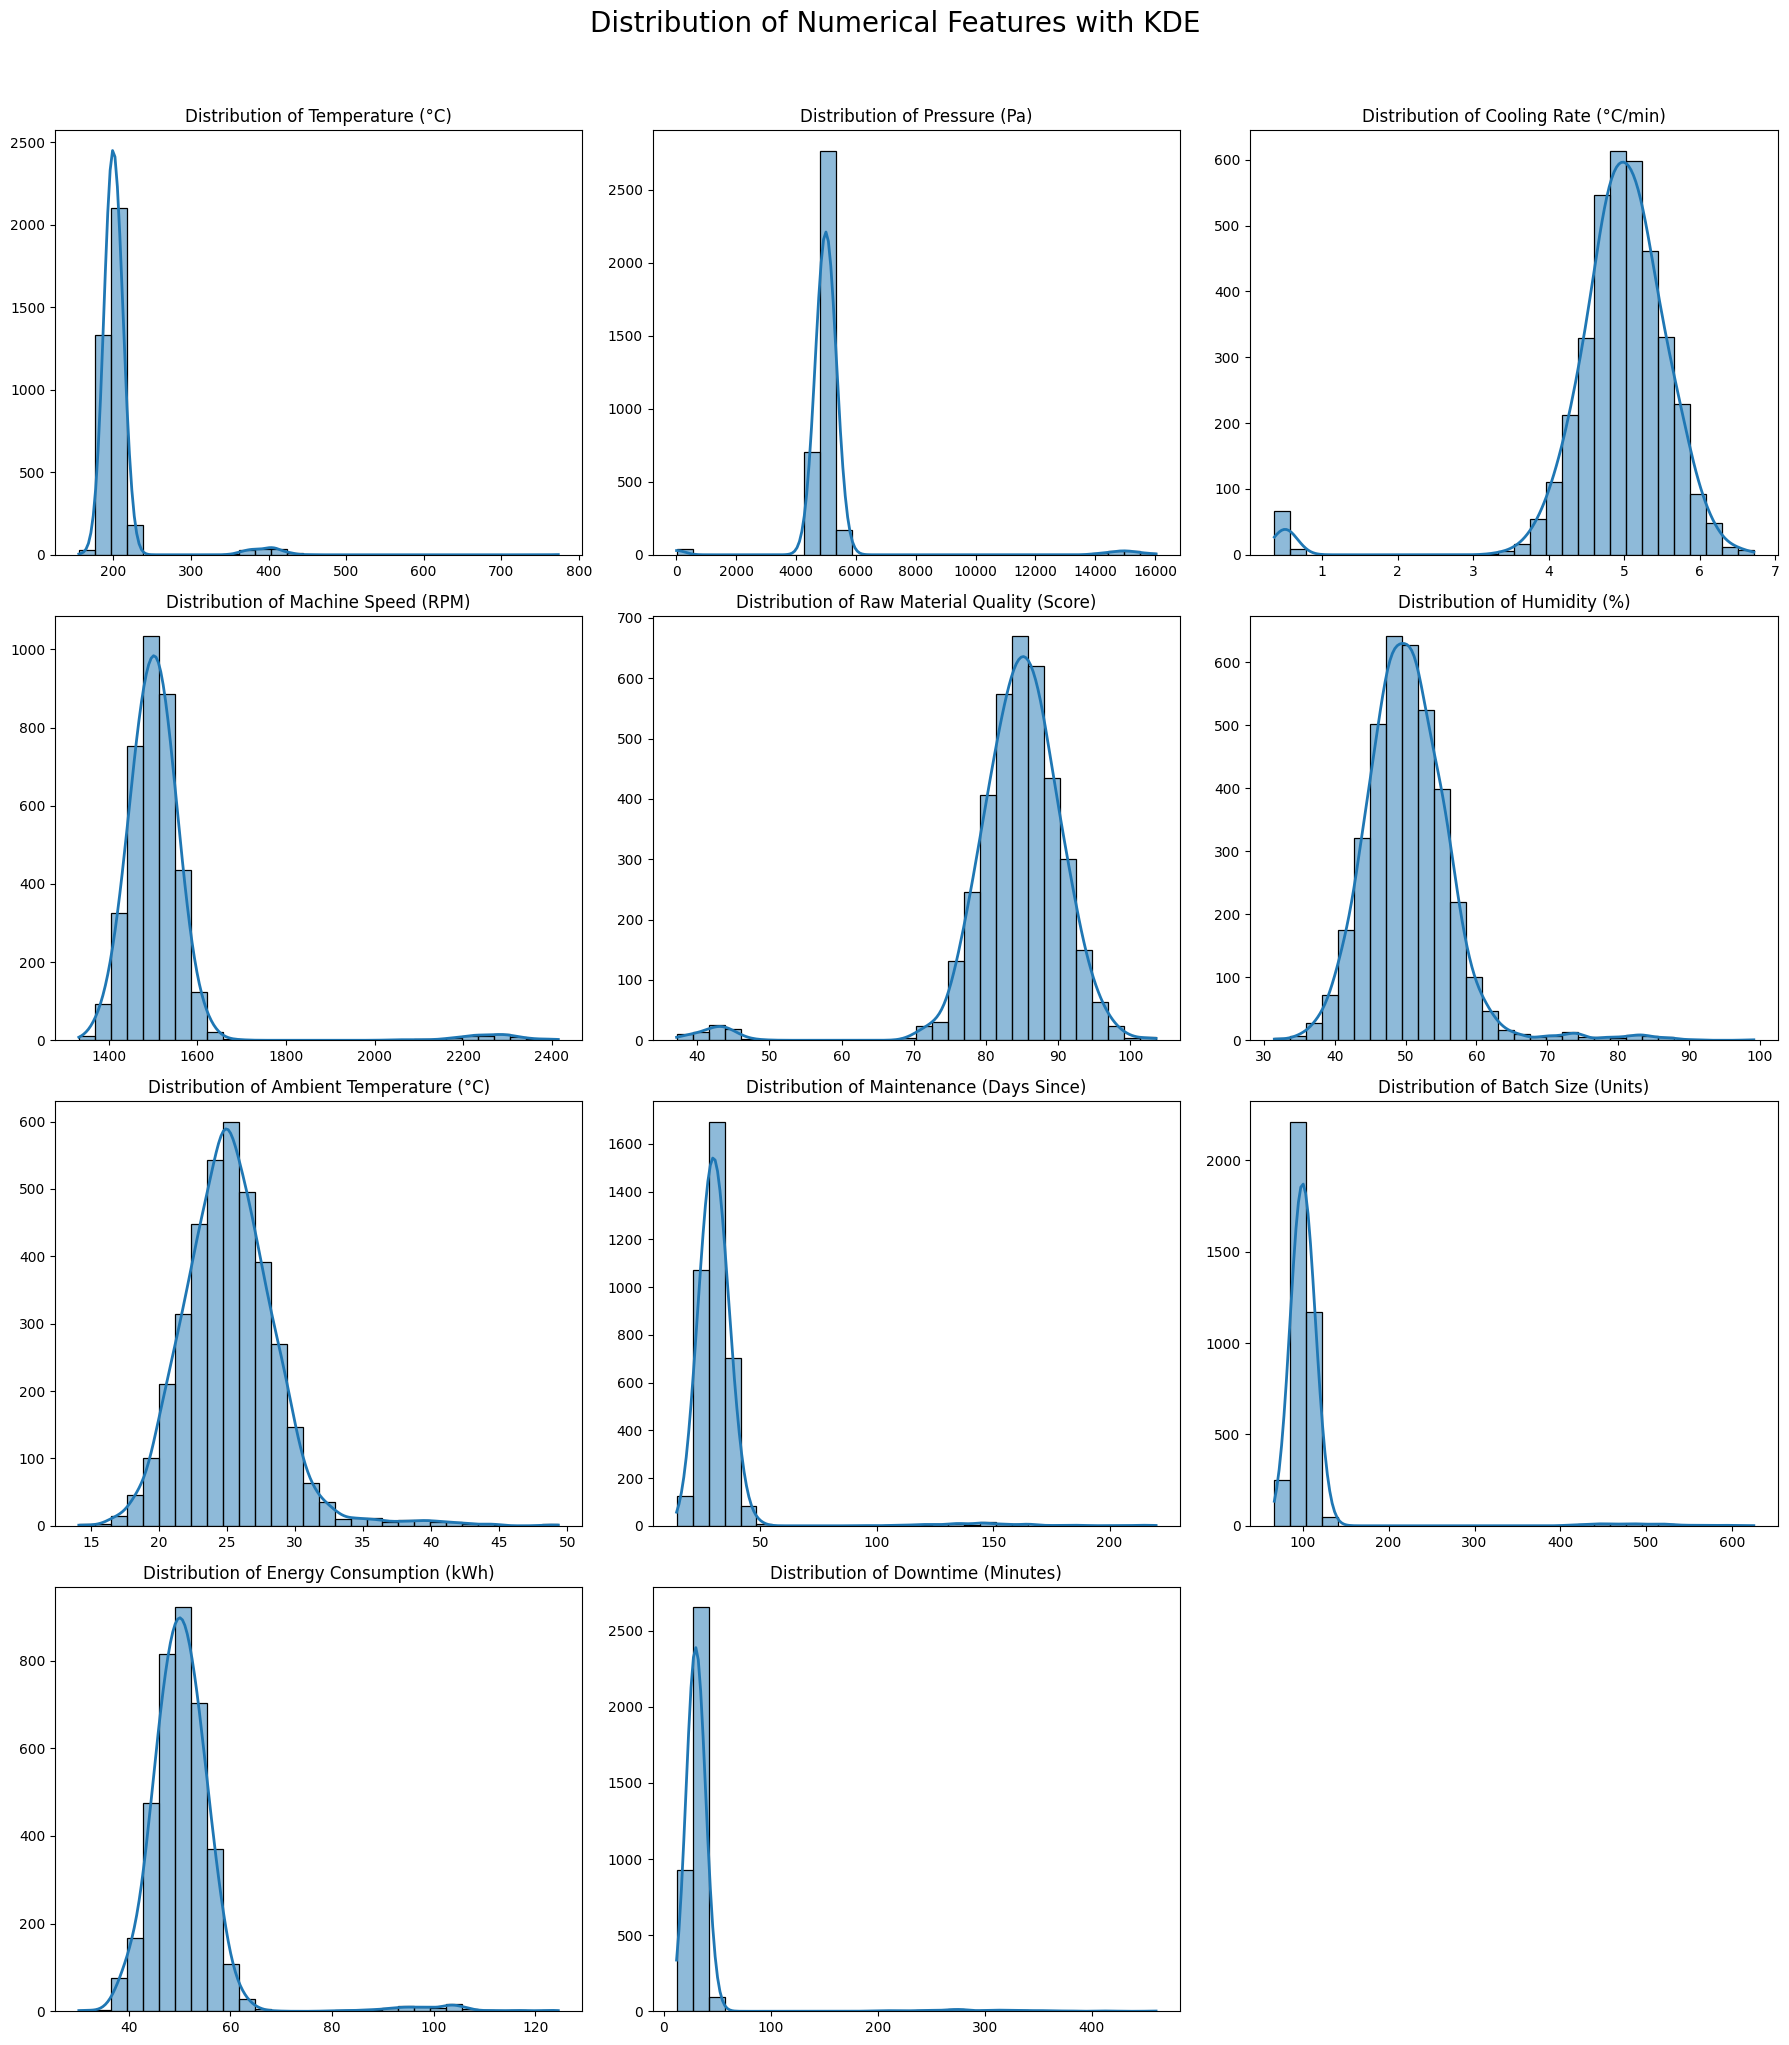

In [13]:
# Distribution Analysis (Histograms with KDE for Numerical Features)
print("\nGenerating and displaying enhanced distribution plots (Histogram + KDE)...")

n_features = len(numeric_features)

# Define the number columns we want
n_cols_hist = 3

# Calculate the required number of rows using ceiling division
n_rows_hist = calculate_grid_rows(n_features, n_cols_hist)

# Create the subplots with the calculated grid size
fig, axes = plt.subplots(n_rows_hist, n_cols_hist, figsize=(18, n_rows_hist * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(data=X, x=col, kde=True, ax=axes[i], bins=30, line_kws={"linewidth": 2})
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# If there are any empty subplots left, turn them off
for j in range(n_features, len(axes)):
    axes[j].axis("off")

plt.suptitle("Distribution of Numerical Features with KDE", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig("../images/numerical_features_distribution_with_kde.png")
plt.show()
plt.close()

### Observations

#### 1. Temperature (°C)
* Right-skewed (long tail to the right).
* Most values concentrated around 200°C.
* A few extreme high-temperature values — possible anomalies or rare events.

#### 2. Pressure (Pa)
* Fairly sharp peak near 5000 Pa.
* Some long tail to the right, likely due to measurement noise or rare process states.
* Slight right-skew; most values lie within a narrow band.

#### 3. Cooling Rate (°C/min)
* Approximately normal distribution centered around 5°C/min.
* Symmetrical and well-behaved — suggests consistent cooling operations.

#### 4. Machine Speed (RPM)
* Slightly right-skewed, concentrated around 1500 RPM.
* Thin tail to the right — few cases of high-speed operation.

#### 5. Raw Material Quality (Score)
* Looks normally distributed around 85.
* Suggests consistent raw material quality with occasional lower scores.

#### 6. Humidity (%)
* Slight left-skew, mode around 50%.
* Wider spread suggests some variation in ambient conditions.

#### 7. Ambient Temperature (°C)
* Approximately normal distribution with peak around 25°C.
* Suggests controlled indoor conditions (likely a factory or lab environment).

#### 8. Maintenance (Days Since)
* Heavily right-skewed.
* Most values close to 0 — machines are recently maintained.
* Long tail indicates delays in maintenance for a few instances — a red flag.

#### 9. Batch Size (Units)
* Right-skewed with a sharp peak around 100 units.
* Few large batches (outliers) — consider segmenting by batch size during analysis.

#### 10. Energy Consumption (kWh)
* Appears roughly normal, centered around 50 kWh.
* Small skew and wide spread — might be batch size dependent.

#### 11. Downtime (Minutes)
* Heavily right-skewed with most values close to 0.
* Few large downtimes — likely major process issues or breakdowns.


Generating and displaying box plots to identify outliers...


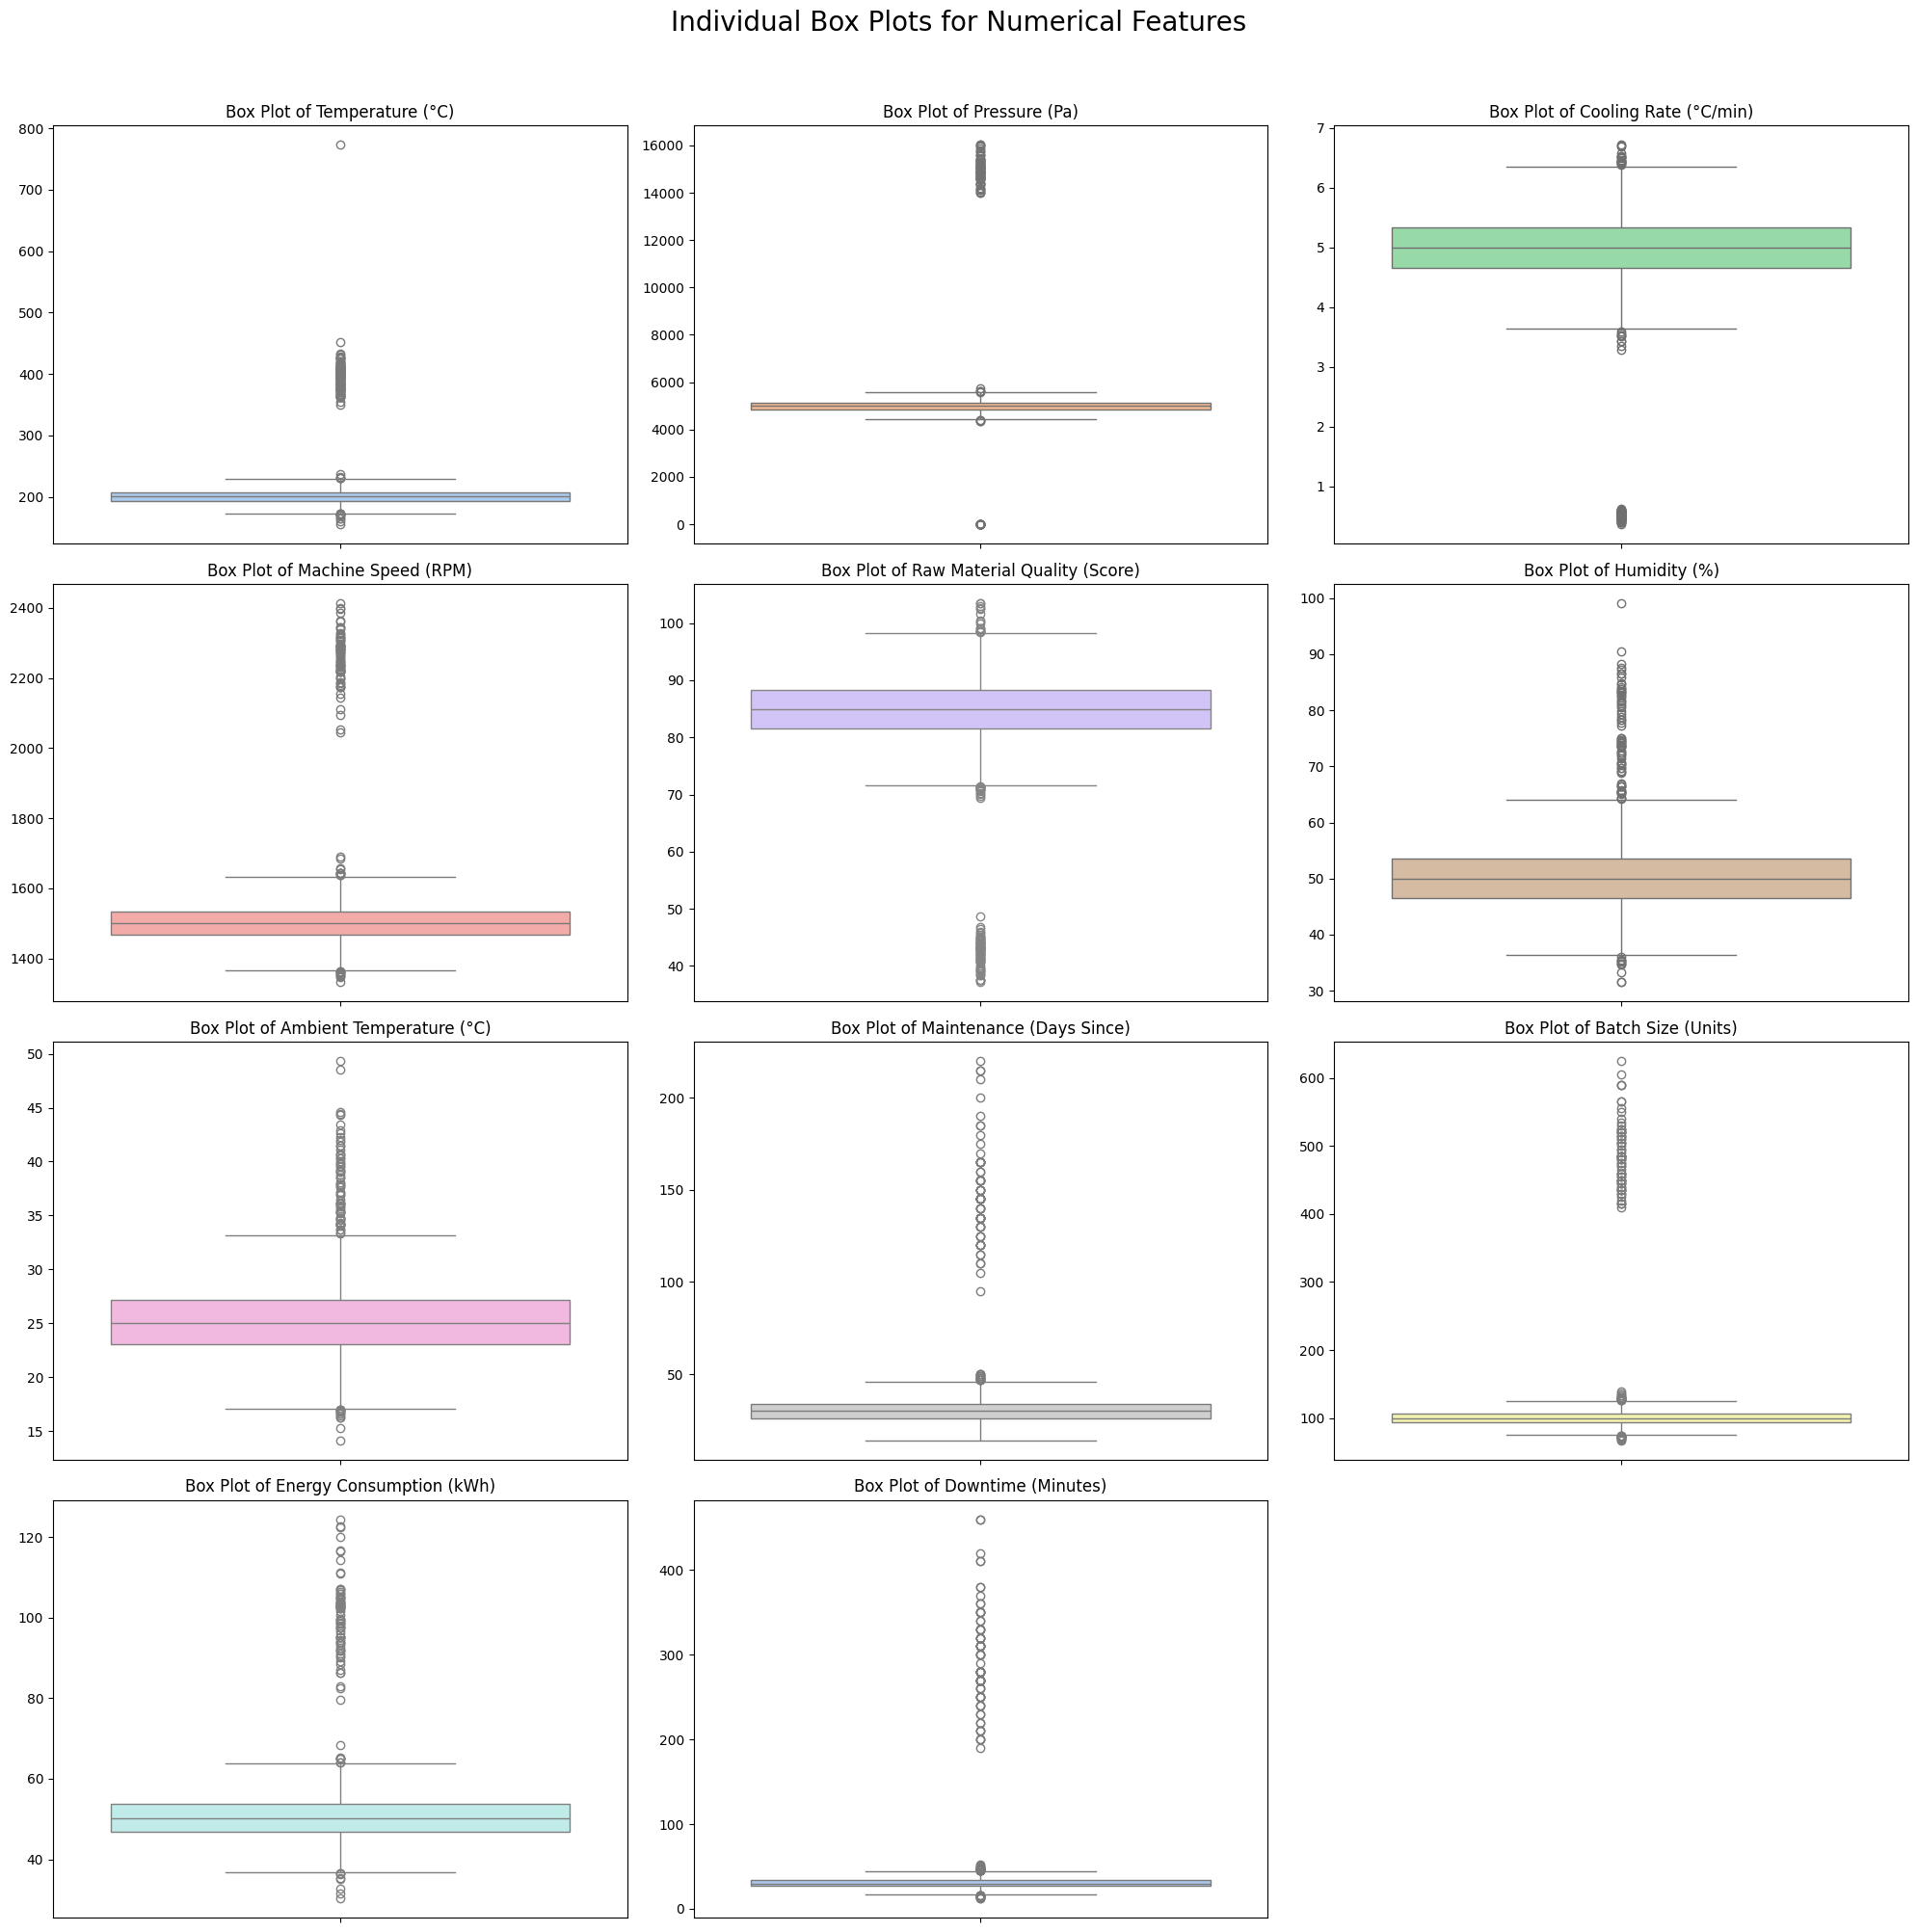

In [14]:
# Outlier Analysis (Box Plots for Numerical Features)
print("\nGenerating and displaying box plots to identify outliers...")

# Define desired columns for box plots
n_cols_box = 3

n_rows_box = calculate_grid_rows(n_features, n_cols_box)

fig, axes = plt.subplots(n_rows_box, n_cols_box, figsize=(20, n_rows_box * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.boxplot(data=X, y=col, ax=axes[i], color=sns.color_palette('pastel')[i % 10])
    axes[i].set_title(f"Box Plot of {col}", fontsize=12)
    axes[i].set_ylabel("")

for j in range(n_features, len(axes)):
    axes[j].axis("off")

plt.suptitle("Individual Box Plots for Numerical Features", fontsize=20, y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("../images/numerical_features_individual_boxplots.png")
plt.show()
plt.close()

### Observations

#### Temperature (°C)
* Median is tightly packed around ~200°C.
* Many high-value outliers, with one extreme value close to 750°C.
* Suggests rare high-temperature events or measurement errors.

#### Pressure (Pa)
* Centered around ~5000 Pa.
* Numerous high outliers, some close to 16,000 Pa.
* Suggests occasional overpressurization or anomalies in process control.

#### Cooling Rate (°C/min)
* Median ~5°C/min.
* A few outliers on both lower and upper ends.
* Mostly consistent, minor outliers may be due to extreme environmental conditions.

#### Machine Speed (RPM)
* Median close to 1500 RPM.
* Several high outliers, some reaching ~2400 RPM.
* Indicates occasional overuse or abnormal process runs.

#### Raw Material Quality (Score)
* Median around 85 — high-quality material.
* A few low and high outliers, including scores close to 40 and 100.
* Indicates inconsistency in raw material supply in some batches.

#### Humidity (%)
* Median ~50%, but large spread and several outliers above 80% and below 40%.
* Suggests fluctuations in environmental control, which could impact process stability.

#### Ambient Temperature (°C)
* Median around 25°C (normal room temperature).
* Outliers on both low (~15°C) and high (~45°C) ends.
* Mostly controlled, with occasional HVAC failures or seasonal shifts.

#### Maintenance (Days Since)
* Median is low, indicating frequent maintenance.
* Many extreme outliers >100 days, suggesting a few neglected machines.
* Raises reliability and downtime risk concerns.

#### Batch Size (Units)
* Median ~100 units.
* Numerous extreme outliers, some batches exceeding 600 units.
* These could correlate with energy consumption or downtime—worth investigating.

#### Energy Consumption (kWh)
* Median ~55 kWh.
* Several high outliers, some exceeding 120 kWh.
* Likely tied to large batch sizes or high-speed operation.

#### Downtime (Minutes)
* Median around 20 minutes.
* Multiple extreme outliers, including some >400 minutes.
* Indicates rare but severe equipment failures or bottlenecks.


Generating and displaying bar charts for categorical features...


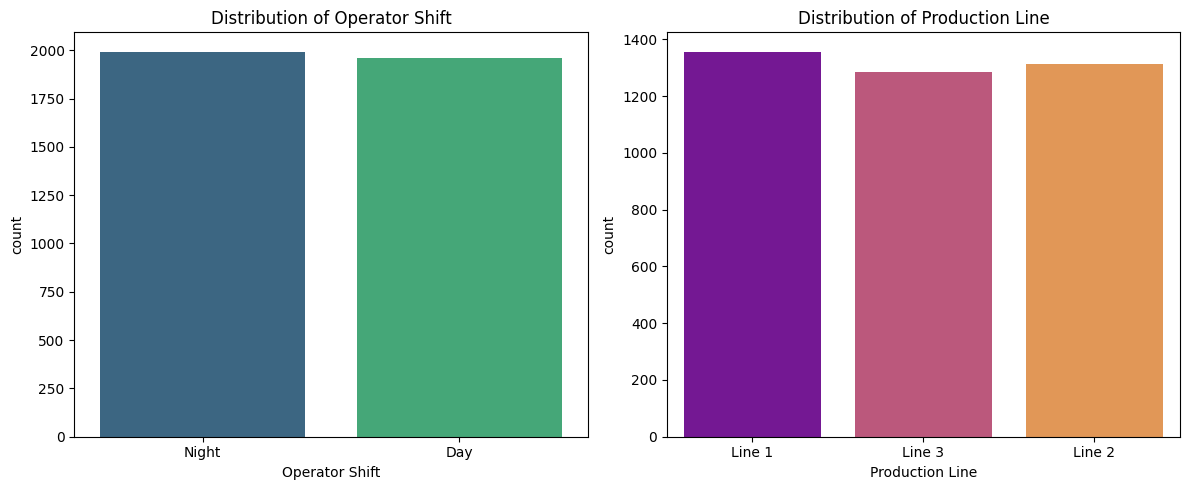

In [15]:
# Categorical Feature Analysis (Bar Charts)
print("\nGenerating and displaying bar charts for categorical features...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(ax=axes[0], x="Operator Shift", data=X, hue="Operator Shift", palette="viridis", legend=False)
axes[0].set_title('Distribution of Operator Shift')
sns.countplot(ax=axes[1], x='Production Line', data=X, hue='Production Line', palette='plasma', legend=False)
axes[1].set_title('Distribution of Production Line')
plt.tight_layout()
plt.savefig("../images/categorical_features_distribution.png")
plt.show()
plt.close()

### Observations
#### Operator Shift
The data is almost perfectly balanced between the "Day" and "Night" shifts. Each shift accounts for roughly the same number of production runs.

#### Production Line
Similarly, the workload is very evenly distributed across the three production lines. "Line 1," "Line 2," and "Line 3" have handled nearly identical numbers of production runs.

## 3. Handle Missing Values

In [16]:
print("Handling Missing Values via Imputation...")

# Identify columns that need imputation (all except the two categorical ones)
numeric_features_with_nan = X.select_dtypes(include=np.number).columns.tolist()

# Use SimpleImputer to fill missing values with the median
imputer = SimpleImputer(strategy='median')
X[numeric_features_with_nan] = imputer.fit_transform(X[numeric_features_with_nan])

Handling Missing Values via Imputation...


In [17]:
print("Missing values after imputation:")
print(X.isnull().sum())
print("\n✅ Imputation complete. The dataset is now free of NaN values.")

Missing values after imputation:
Temperature (°C)                0
Pressure (Pa)                   0
Cooling Rate (°C/min)           0
Machine Speed (RPM)             0
Raw Material Quality (Score)    0
Humidity (%)                    0
Ambient Temperature (°C)        0
Maintenance (Days Since)        0
Operator Shift                  0
Batch Size (Units)              0
Energy Consumption (kWh)        0
Production Line                 0
Downtime (Minutes)              0
dtype: int64

✅ Imputation complete. The dataset is now free of NaN values.


## 4. Feature Engineering

In [18]:
print("Performing Feature Engineering on the imputed dataset...")

# Create new features
X['Energy_per_Unit'] = X['Energy Consumption (kWh)'] / (X['Batch Size (Units)'] + 1e-6)
X['Process_Stress_Index'] = X['Temperature (°C)'] * X['Pressure (Pa)']

print("Created 2 new features: 'Energy_per_Unit', 'Process_Stress_Index''")
print("Sample of engineered features:")
print(X[['Energy_per_Unit', 'Process_Stress_Index']].head())

Performing Feature Engineering on the imputed dataset...
Created 2 new features: 'Energy_per_Unit', 'Process_Stress_Index''
Sample of engineered features:
   Energy_per_Unit  Process_Stress_Index
0         0.483760          1.035330e+06
1         0.466911          1.172323e+06
2         0.423094          1.087975e+06
3         0.498629          1.043808e+06
5         0.540595          9.713813e+05


In [19]:
X.head()

,Temperature (°C),Pressure (Pa),Cooling Rate (°C/min),Machine Speed (RPM),Raw Material Quality (Score),Humidity (%),Ambient Temperature (°C),Maintenance (Days Since),Operator Shift,Batch Size (Units),Energy Consumption (kWh),Production Line,Downtime (Minutes),Energy_per_Unit,Process_Stress_Index
0,199.587579,5187.346865,4.197020,1467.853751,77.249494,54.419352,22.916290,36.0,Night,104.0,50.311084,Line 1,25.0,0.483760,1.035330e+06
1,224.800678,5214.943372,4.561051,1522.273687,76.700630,56.171668,22.872015,28.0,Night,100.0,46.691092,Line 1,37.0,0.466911,1.172323e+06
2,224.027162,4856.441687,4.936852,1423.536278,80.541510,49.527377,29.149278,25.0,Day,97.0,41.040091,Line 1,30.0,0.423094,1.087975e+06
3,204.448237,5105.486001,5.156183,1553.104489,85.953493,51.710811,27.805151,24.0,Day,100.0,49.862947,Line 3,26.0,0.498629,1.043808e+06
5,194.351791,4998.056751,4.990523,1377.052073,77.254139,46.126203,24.799779,35.0,Night,106.0,57.303122,Line 1,28.0,0.540595,9.713813e+05


Visualizing distributions of ALL features after imputation and engineering...


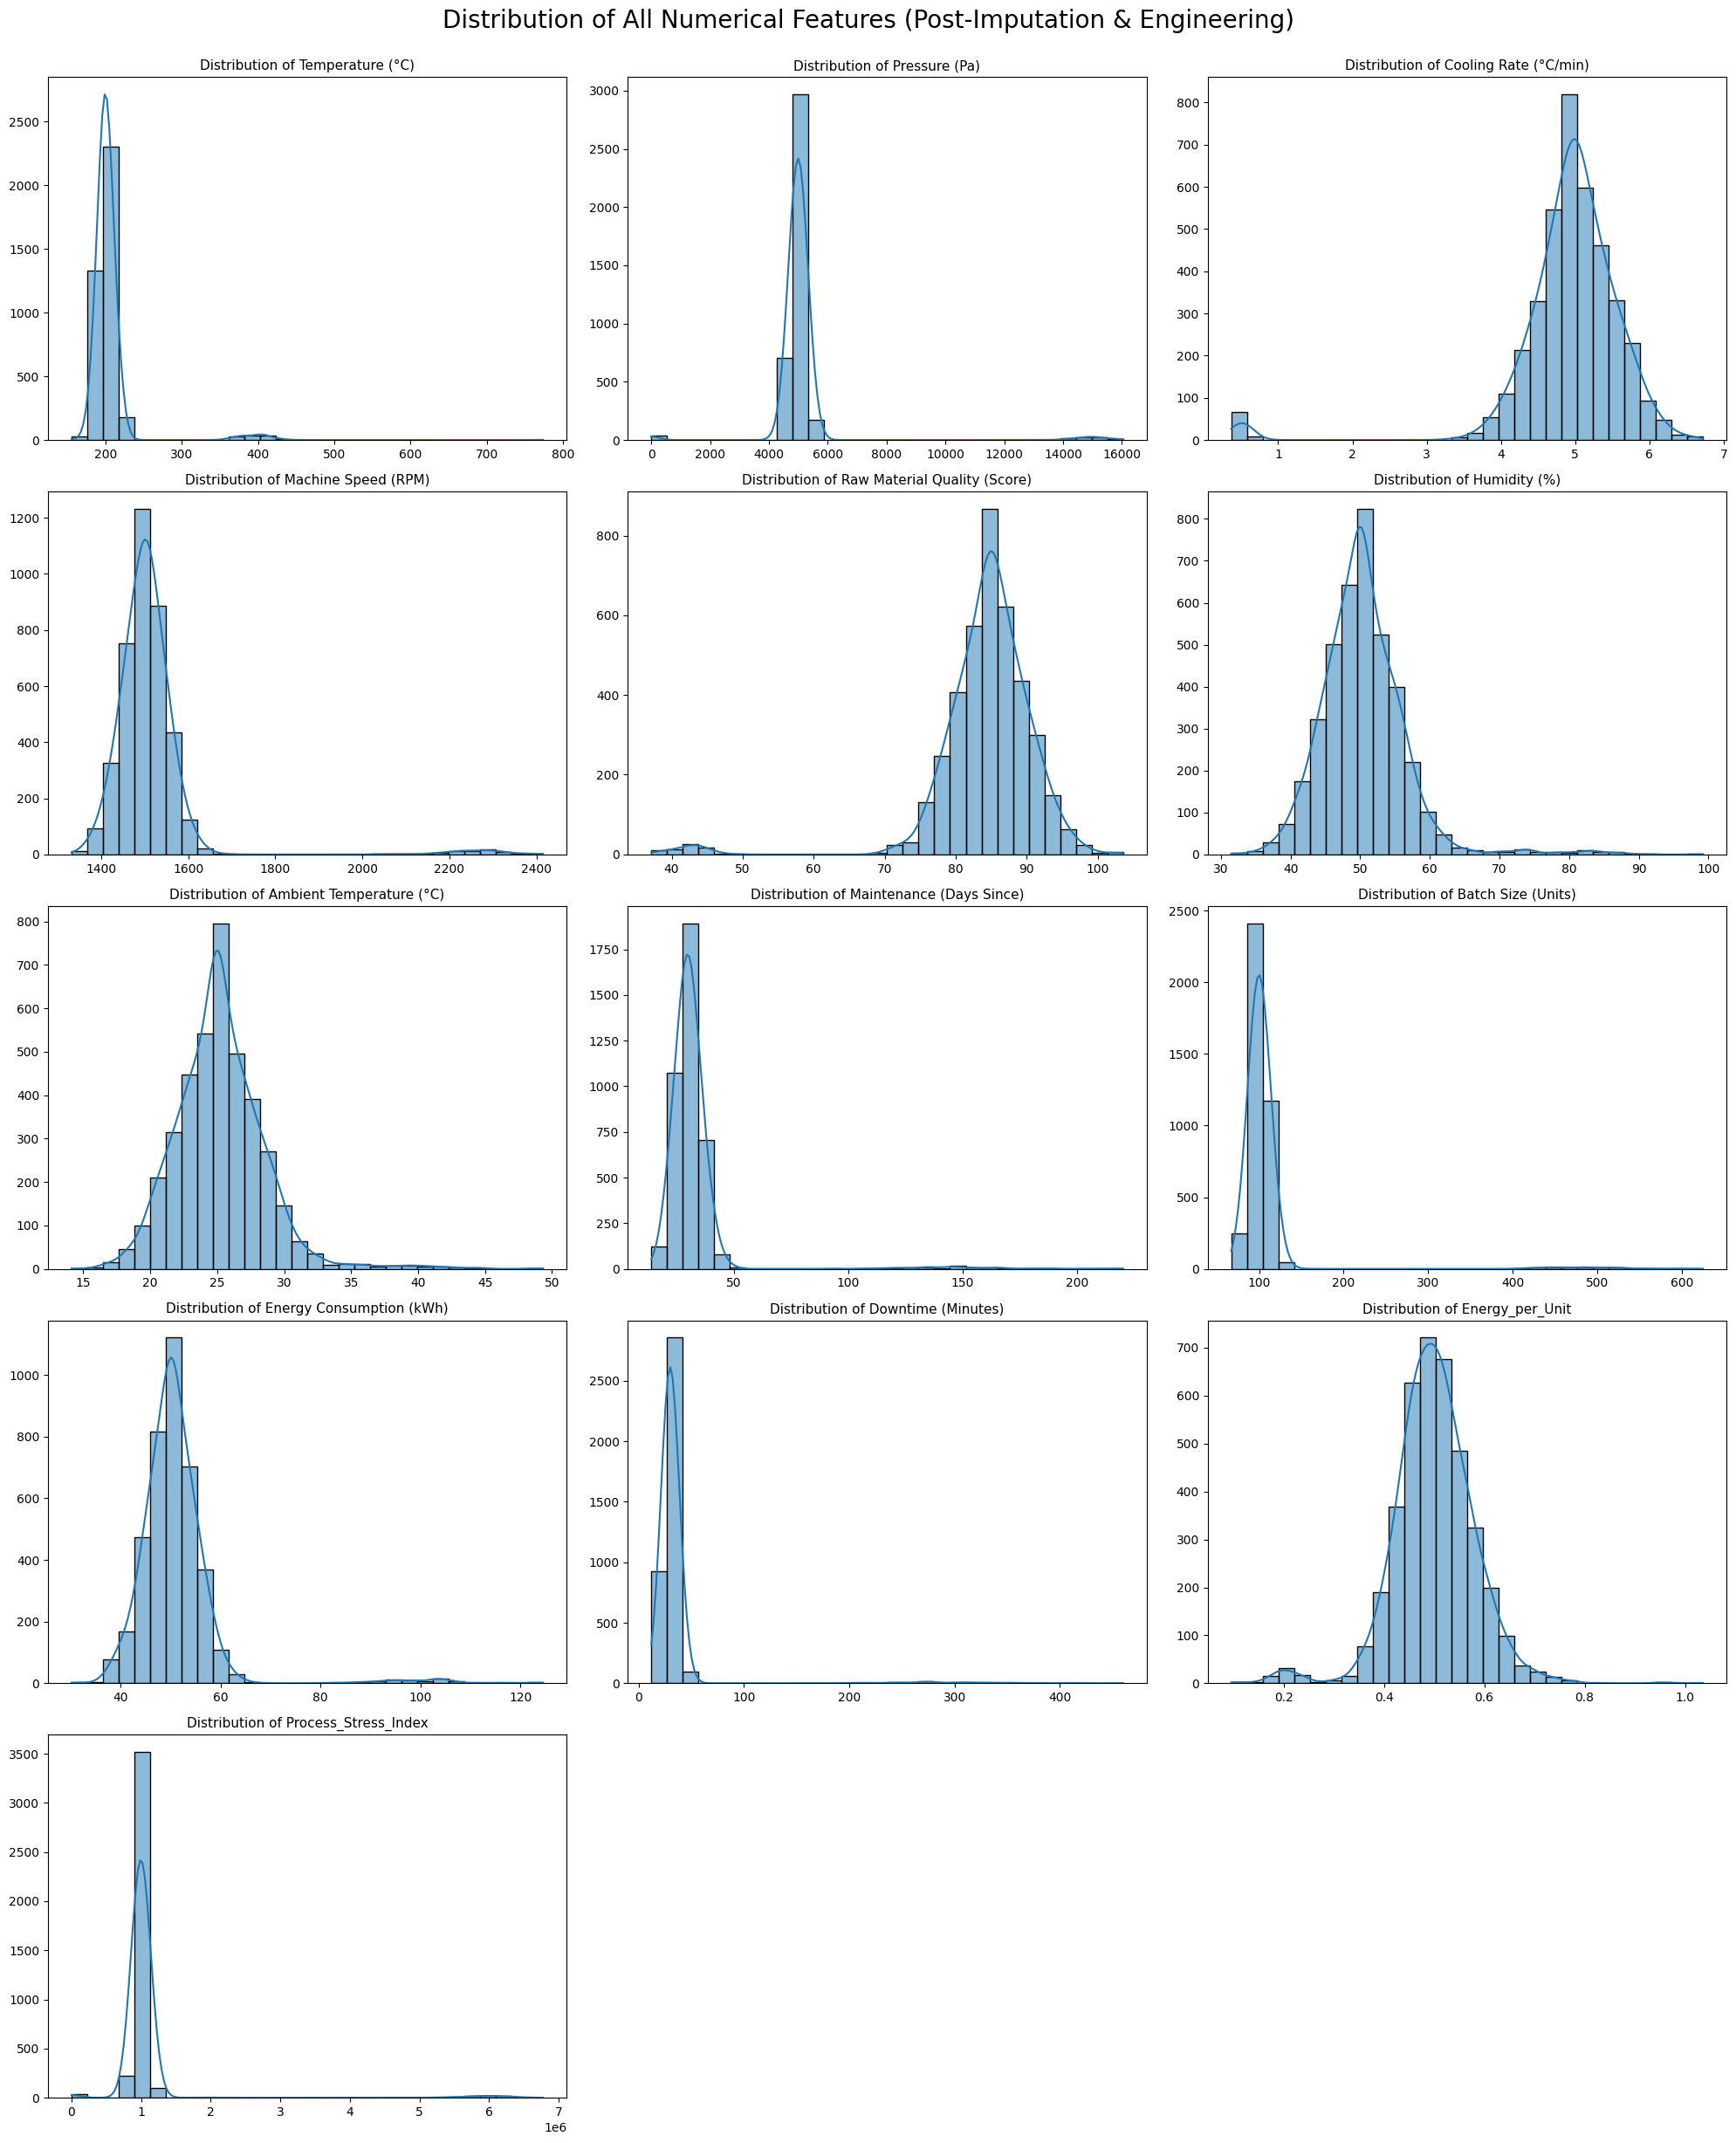

In [20]:
print("Visualizing distributions of ALL features after imputation and engineering...")

features_to_plot = X.select_dtypes(include=np.number).columns.tolist()
n_features = len(features_to_plot)

n_cols = 3
n_rows = calculate_grid_rows(n_features, n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.histplot(data=X, x=col, kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f"Distribution of {col}", fontsize=11)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide any unused subplots
for j in range(n_features, len(axes)):
    axes[j].axis('off')

plt.suptitle("Distribution of All Numerical Features (Post-Imputation & Engineering)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("../images/all_features_post_imputation_distribution.png")
plt.show()
plt.close()

### Observations

#### Temperature (°C)
* Still slightly right-skewed, but outlier impact is reduced.
* Distribution has a sharper peak, suggesting less noise and possibly fewer faulty records.

#### Pressure (Pa)
* More normal-like distribution, centered around 5000 Pa.
* High-pressure anomalies from earlier are now smoothed — consistent control range.

#### Cooling Rate (°C/min)
* Distribution is tighter and more symmetric around ~5°C/min.
* Implies successful standardization of this operational parameter.

#### Machine Speed (RPM)
* Right-skew reduced; peak around ~1500 RPM.
* Some long-tail behavior remains, which might be due to operational flexibility.

#### Raw Material Quality (Score)
* Now close to Gaussian, centered around 85.
* Implies successful handling of missing/imperfect raw material quality scores.

#### Humidity (%)
* Still a bit left-skewed, but peak around 50% is clear.
* Outliers from earlier were likely clipped/imputed.

#### Ambient Temperature (°C)
* Near-normal distribution centered around 25°C.
* A clean environmental signal post-cleaning — HVAC data looks reliable.

#### Maintenance (Days Since)
* Distribution now leans left (more frequent maintenance), with a longer tail for infrequent cases.
* Compared to earlier, extreme delays in maintenance are significantly reduced — a major improvement.

#### Batch Size (Units)
* Right-skew remains but is tighter and more structured.
* Still has some longer batches, possibly by design (product-specific).

#### Energy Consumption (kWh)
* Almost normal, centered ~55 kWh.
* Likely cleaned to match batch-size constraints.

#### Downtime (Minutes)
* Long tail still exists but most values cluster below 50 mins.
* Severe outliers are now gone, reflecting proper capping or imputation.

#### Process_Stress_Index
* Strong right skew with a heavy tail.
* Indicates most processes run in a moderate range, with a few high-stress scenarios.

#### Energy_per_Unit
* Almost perfectly Gaussian, centered ~1 kWh/unit.
* Excellent engineered feature for normalization — likely to help control for batch size impact.

## 5. Data Preprocessing

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Define feature groups based on observations
# list of skewed features
skewed_features = [
    'Temperature (°C)', 'Pressure (Pa)', 'Maintenance (Days Since)',
    'Batch Size (Units)', 'Downtime (Minutes)',
    'Process_Stress_Index'
]

symmetric_features = [
    'Cooling Rate (°C/min)', 'Machine Speed (RPM)', 'Raw Material Quality (Score)',
    'Humidity (%)', 'Ambient Temperature (°C)', 'Energy Consumption (kWh)', 'Energy_per_Unit'
]

categorical_features = ['Operator Shift', 'Production Line']

* NOTE on Outlier Handling: We are using log transform which implicitly handles outliers by reducing their magnitude. No separate capping step is needed, as it can be overly aggressive.

In [23]:
# Create Pipelines
log_transformer = FunctionTransformer(np.log1p)

skewed_pipeline = Pipeline(
    steps=[
        ("log", log_transformer),
        ("scale", StandardScaler())
    ]
)

symmetric_pipeline = Pipeline(
    steps=[
        ("scale", StandardScaler())
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

In [24]:
# Assemble preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("skewed", skewed_pipeline, skewed_features),
        ("symmetric", symmetric_pipeline, symmetric_features),
        ("cat", categorical_pipeline, categorical_features)
    ],
    remainder="passthrough"
)

In [25]:
# Fit on training data and transform both train and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [26]:
# Get feature names for DataFrames
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = skewed_features + symmetric_features + list(ohe_feature_names)

In [27]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

print("✅ Preprocessing complete. Log transform applied and data scaled.")

✅ Preprocessing complete. Log transform applied and data scaled.


In [28]:
X_train_processed_df.head()

,Temperature (°C),Pressure (Pa),Maintenance (Days Since),Batch Size (Units),Downtime (Minutes),Process_Stress_Index,Cooling Rate (°C/min),Machine Speed (RPM),Raw Material Quality (Score),Humidity (%),Ambient Temperature (°C),Energy Consumption (kWh),Energy_per_Unit,Operator Shift_Day,Operator Shift_Night,Production Line_Line 1,Production Line_Line 2,Production Line_Line 3
0,-0.125425,0.068112,0.137592,0.233042,0.158183,0.048610,0.098819,0.107513,0.502937,0.864858,-0.225439,0.254468,-0.114481,0.0,1.0,0.0,0.0,1.0
1,0.101589,0.006263,-0.698889,-0.376160,-0.909679,0.028400,0.091083,-0.499194,1.140937,0.502035,-0.276212,-0.903874,-0.474325,0.0,1.0,1.0,0.0,0.0
2,0.503270,0.083843,0.539009,-0.163014,-0.471616,0.183812,0.591219,0.485814,-0.150088,0.045621,-0.583364,-0.105917,0.096788,0.0,1.0,0.0,0.0,1.0
3,-0.252090,0.103223,-0.315756,-0.289585,0.669653,0.060498,1.514134,-0.109941,0.833247,0.922562,-1.204839,-0.264205,0.113593,1.0,0.0,0.0,1.0,0.0
4,0.537765,-0.065722,0.812542,0.195093,-0.094184,0.037445,-0.027804,0.080103,0.621226,1.092646,1.094870,0.386761,0.069383,1.0,0.0,0.0,1.0,0.0


## 6. Correlation and Feature Selection

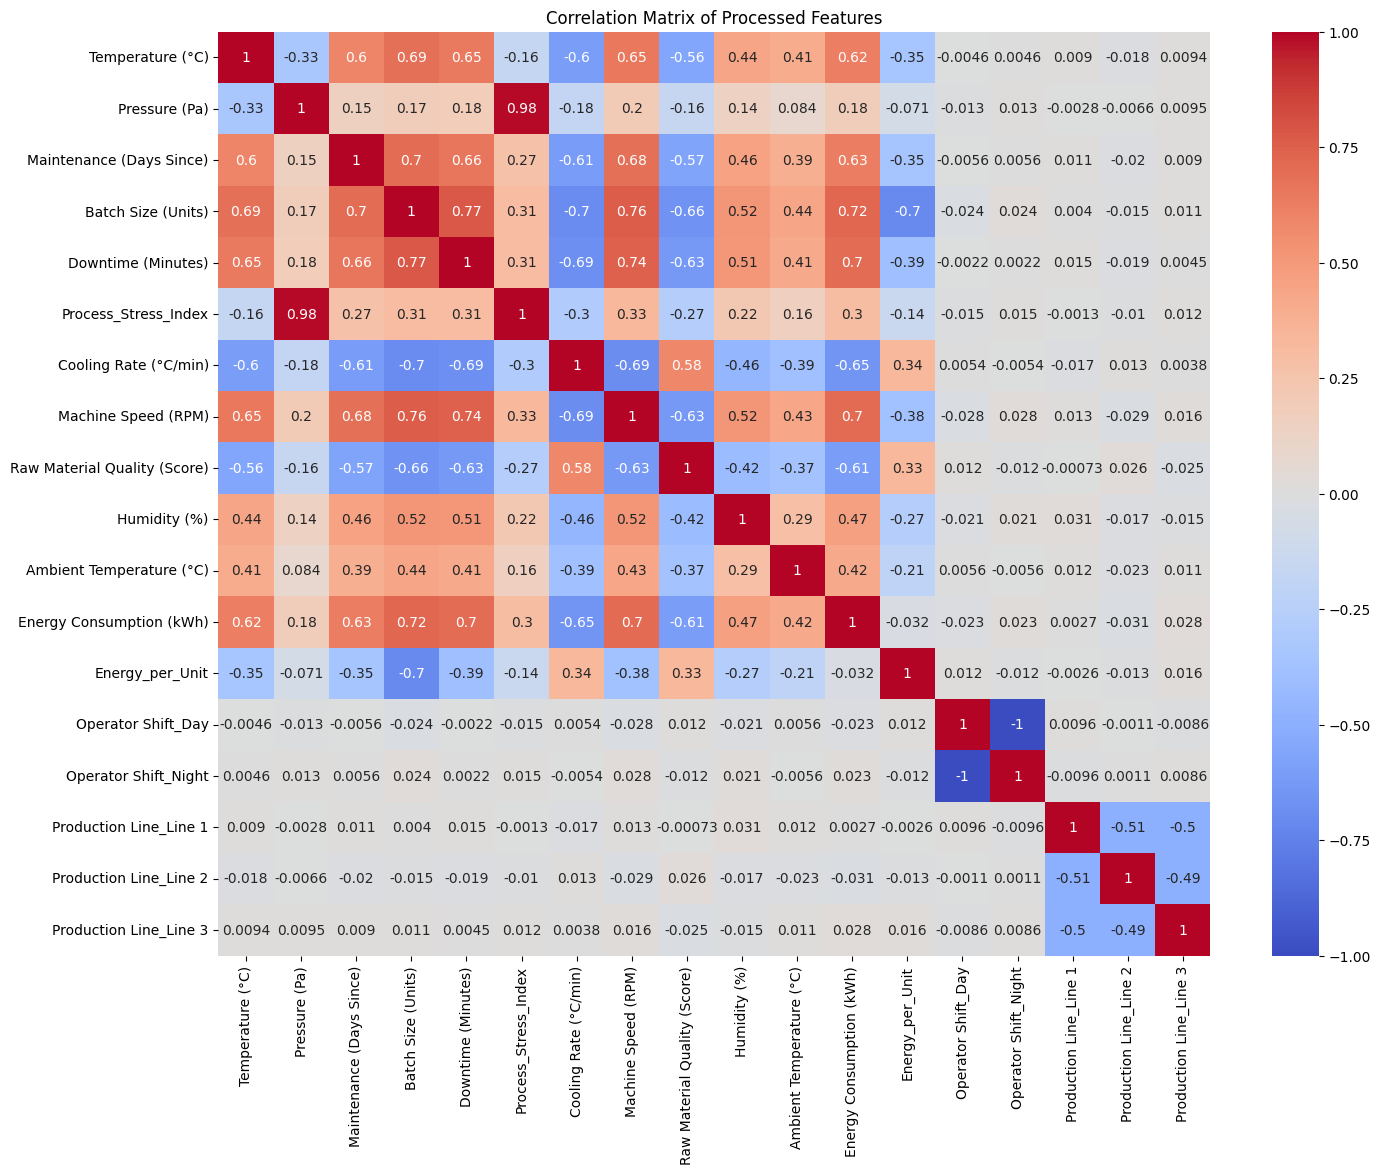

In [29]:
# --- Correlation Analysis ---
plt.figure(figsize=(16, 12))
correlation_matrix = X_train_processed_df.corr()
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    annot=True
)
plt.title("Correlation Matrix of Processed Features")
plt.savefig("../images/correlation_heatmap_defect_model.png")
plt.show()
plt.close()

In [30]:
correlation_matrix

,Temperature (°C),Pressure (Pa),Maintenance (Days Since),Batch Size (Units),Downtime (Minutes),Process_Stress_Index,Cooling Rate (°C/min),Machine Speed (RPM),Raw Material Quality (Score),Humidity (%),Ambient Temperature (°C),Energy Consumption (kWh),Energy_per_Unit,Operator Shift_Day,Operator Shift_Night,Production Line_Line 1,Production Line_Line 2,Production Line_Line 3
Temperature (°C),1.000000,-0.333503,0.596853,0.686132,0.646762,-0.164765,-0.602126,0.649363,-0.558758,0.439887,0.405736,0.617508,-0.349063,-0.004635,0.004635,0.009038,-0.018360,0.009357
Pressure (Pa),-0.333503,1.000000,0.150773,0.172829,0.182776,0.984805,-0.177898,0.202886,-0.159488,0.136663,0.083773,0.176129,-0.070543,-0.013155,0.013155,-0.002842,-0.006558,0.009464
Maintenance (Days Since),0.596853,0.150773,1.000000,0.695873,0.660509,0.266932,-0.613575,0.680430,-0.566678,0.455469,0.388436,0.630829,-0.353696,-0.005605,0.005605,0.010644,-0.019663,0.009049
Batch Size (Units),0.686132,0.172829,0.695873,1.000000,0.774806,0.306292,-0.699743,0.764465,-0.660271,0.522937,0.444198,0.720912,-0.703483,-0.024451,0.024451,0.003958,-0.014576,0.010673
Downtime (Minutes),0.646762,0.182776,0.660509,0.774806,1.000000,0.309543,-0.687078,0.742476,-0.628630,0.510367,0.414147,0.701750,-0.391658,-0.002152,0.002152,0.014816,-0.019275,0.004451
Process_Stress_Index,-0.164765,0.984805,0.266932,0.306292,0.309543,1.000000,-0.296269,0.330726,-0.269066,0.223372,0.161975,0.297226,-0.137578,-0.014601,0.014601,-0.001258,-0.010232,0.011563
Cooling Rate (°C/min),-0.602126,-0.177898,-0.613575,-0.699743,-0.687078,-0.296269,1.000000,-0.688666,0.584467,-0.457360,-0.387050,-0.651961,0.335260,0.005436,-0.005436,-0.017127,0.013356,0.003833
Machine Speed (RPM),0.649363,0.202886,0.680430,0.764465,0.742476,0.330726,-0.688666,1.000000,-0.631557,0.516327,0.430939,0.704256,-0.378238,-0.027993,0.027993,0.012822,-0.028691,0.015936
Raw Material Quality (Score),-0.558758,-0.159488,-0.566678,-0.660271,-0.628630,-0.269066,0.584467,-0.631557,1.000000,-0.416478,-0.372461,-0.606594,0.329148,0.011690,-0.011690,-0.000732,0.025936,-0.025355
Humidity (%),0.439887,0.136663,0.455469,0.522937,0.510367,0.223372,-0.457360,0.516327,-0.416478,1.000000,0.287965,0.466120,-0.266887,-0.020932,0.020932,0.031095,-0.016512,-0.014744


### Observations

* **High Correlation Identified:** The heatmap shows a few bright red squares, indicating very strong positive correlations. Specifically, `Pressure`, `Temperature`, and the engineered `Process_Stress_Index` are all highly correlated with each other.
* **Expected Finding:** This is expected because we created `Process_Stress_Index` by multiplying `Temperature` and `Pressure`. This confirms they carry redundant information.

/var/folders/tm/lpcq7lb52_xblwgjpmlk5mh00000gn/T/ipykernel_87430/2930037180.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="viridis")


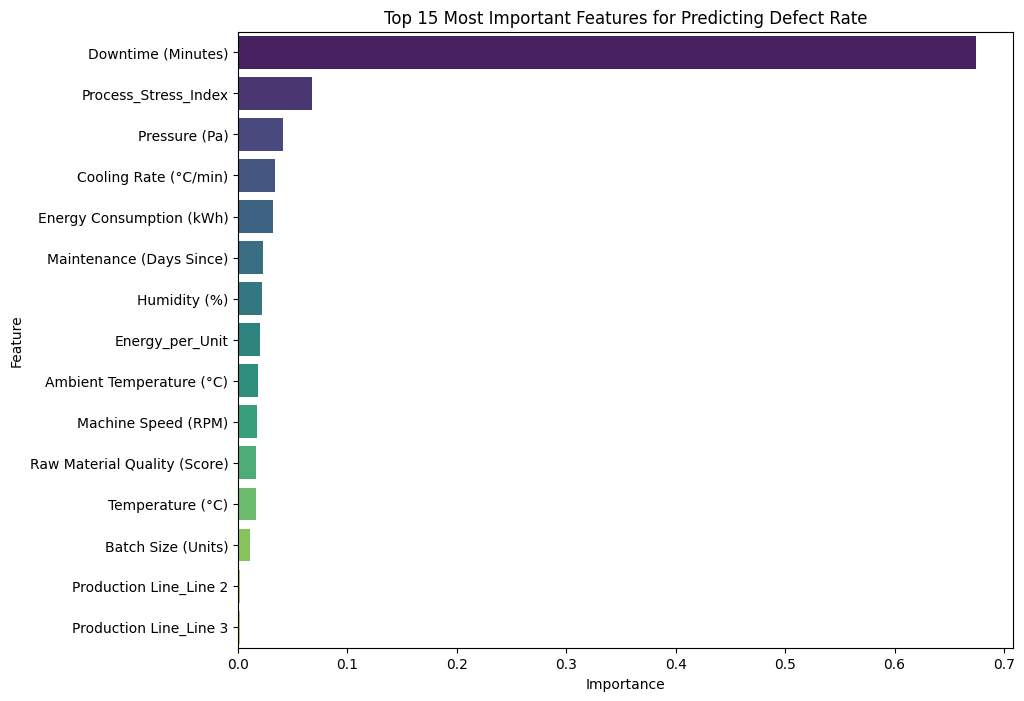

In [31]:
# --- Feature Importance Analysis ---
# Train a Random Forest to get feature importances
rf_importances = RandomForestRegressor(n_estimators=100, random_state=42)
rf_importances.fit(X_train_processed, y_train)
importances = rf_importances.feature_importances_
importance_df = pd.DataFrame(
    {
        "Feature": all_feature_names,
        "Importance": importances
    }
)
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="viridis")
plt.title("Top 15 Most Important Features for Predicting Defect Rate")
plt.savefig("../images/feature_importance_defect_model.png")
plt.show()
plt.close()

In [32]:
print("\nTop 10 most important features:")
print(importance_df.head(10))


Top 10 most important features:
                     Feature  Importance
4         Downtime (Minutes)    0.674541
5       Process_Stress_Index    0.068057
1              Pressure (Pa)    0.041130
6      Cooling Rate (°C/min)    0.033817
11  Energy Consumption (kWh)    0.032175
2   Maintenance (Days Since)    0.022396
9               Humidity (%)    0.021594
12           Energy_per_Unit    0.020021
10  Ambient Temperature (°C)    0.018133
7        Machine Speed (RPM)    0.017689


### Observations

* **Dominant Feature:** `Downtime (Minutes)` is overwhelmingly the most important feature for predicting `Defect Rate`, with an importance score of over 67%. This is a powerful insight, suggesting that process interruptions are the single biggest driver of quality issues.

* **Secondary Drivers:** After `Downtime`, factors related to process conditions (`Process_Stress_Index`, `Pressure`, `Cooling Rate`) and energy usage have a much smaller, secondary impact.

In [33]:
# --- Multicollinerarity Check (VIF) ---
# VIF is calculated on the preprocessed training data
vif_data = X_train_processed_df[importance_df["Feature"].head(10)] # Check top 10 features
vif_info = pd.DataFrame()
vif_info["Feature"] = vif_data.columns
vif_info["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
print("\nVariance Inflation Factor (VIF) for Top Features:")
print(vif_info)


Variance Inflation Factor (VIF) for Top Features:
                    Feature         VIF
0        Downtime (Minutes)    3.302145
1      Process_Stress_Index  132.900692
2             Pressure (Pa)  121.796692
3     Cooling Rate (°C/min)    2.487096
4  Energy Consumption (kWh)    3.781695
5  Maintenance (Days Since)    2.340930
6              Humidity (%)    1.487083
7           Energy_per_Unit    1.756833
8  Ambient Temperature (°C)    1.318473
9       Machine Speed (RPM)    3.422059


### Observations

* The Variance Inflation Factor (VIF) scores confirm a severe multicollinearity problem. A VIF score above 5-10 is considered high.
* **Problem Features:** Process_Stress_Index (VIF ≈ 133) and Pressure (VIF ≈ 122) have extremely high scores. This mathematically proves they are redundant and will make linear models unstable and feature importances unreliable.
* **Healthy Features:** All other top features have excellent VIF scores (well below 5), indicating they are independent.

### Main Takeaway for Next Step

* The most critical finding is the severe multicollinearity between `Pressure`, `Temperature`, and `Process_Stress_Index`. While tree-based models can handle this for prediction, it makes the model difficult to interpret and unstable.
* The simplest and most effective action is to remove the `Process_Stress_Index` feature from the dataset and run the modeling. Since this feature was engineered directly from `Temperature` and `Pressure`, we will lose very little information but gain a much more stable and interpretable model.

In [34]:
print("Refining Feature Set by Removing Columns with High VIF...")

# Define columns to drop based on our VIF analysis
cols_to_drop = ['Process_Stress_Index', 'Pressure (Pa)']

# Drop these columns from the already processed train and test sets
X_train_final = X_train_processed_df.drop(columns=cols_to_drop)
X_test_final = X_test_processed_df.drop(columns=cols_to_drop)

print(f"Removed {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"Final number of features for modeling: {X_train_final.shape[1]}")

Refining Feature Set by Removing Columns with High VIF...
Removed 2 columns: ['Process_Stress_Index', 'Pressure (Pa)']
Final number of features for modeling: 16


## 7. Modeling & Evaluation

In [35]:
print("Training and Evaluating Final Models on the Refined Feature Set...")

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    # Train the model on training data
    model.fit(X_train_final, y_train)
    # Evaluate on the final, refined test data
    train_r2 = r2_score(y_train, model.predict(X_train_final))
    test_r2 = r2_score(y_test, model.predict(X_test_final))

    results.append(
        {
            "Model": name,
            "Train R-squared": train_r2,
            "Test R-squared": test_r2,
        }
    )

results_df = pd.DataFrame(results).sort_values(by='Test R-squared', ascending=False)

print("\n--- Final Model Performance (Predicting Defect Rate) ---")
print(results_df)

Training and Evaluating Final Models on the Refined Feature Set...
Training Ridge...
Training Random Forest...
Training Gradient Boosting...

--- Final Model Performance (Predicting Defect Rate) ---
               Model  Train R-squared  Test R-squared
1      Random Forest         0.968248        0.697192
2  Gradient Boosting         0.858443        0.674049
0              Ridge         0.748942        0.644762


The models are overfitting. We can clearly see this by comparing the `Train R-squared` to the `Test R-squared`.

* Random Forest: Shows the most overfitting. It gets a near-perfect score on the training data (0.968) but is less accurate on the test data (0.697).
* Gradient Boosting & Ridge: Also show this pattern, just to a lesser degree.

## 8. Hyperparameter Tuning

In [36]:
print("Starting Hyperparameter Tuning for Random Forest...")

# Define a focused parameter grid to control overfitting
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],        # Prevents trees from getting too deep
    'min_samples_leaf': [5, 10, 15],  # Requires more samples to create a leaf
    'max_features': ['sqrt', 1.0] # Number of features to consider for best split
}

# Setup and run GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_final, y_train)

print("\nBest parameters found:", grid_search.best_params_)
best_rf_tuned = grid_search.best_estimator_

Starting Hyperparameter Tuning for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=

In [37]:
# Evaluate the newly tuned model
print("Evaluating the tuned random forest model on both Train and Test Sets...")

# --- Evaluate on Training Set ---
y_pred_train_tuned = best_rf_tuned.predict(X_train_final)
train_r2_tuned = r2_score(y_train, y_pred_train_tuned)

# --- Evaluate on Test Set ---
y_pred_test_tuned = best_rf_tuned.predict(X_test_final)
test_r2_tuned = r2_score(y_test, y_pred_test_tuned)

# --- Display Final Results ---
final_results = {
    'Metric': ['Train R-squared', 'Test R-squared'],
    'Score': [train_r2_tuned, test_r2_tuned]
}
final_results_df = pd.DataFrame(final_results)

print("\n--- Performance of Tuned Random Forest ---")
print(final_results_df)

Evaluating the tuned random forest model on both Train and Test Sets...

--- Performance of Tuned Random Forest ---
            Metric     Score
0  Train R-squared  0.829722
1   Test R-squared  0.711050


There is still a small, acceptable amount of overfitting. The gap between the Train R-squared (0.83) and the Test R-squared (0.71) shows that the model still performs slightly better on the data it has already seen.

In [38]:
print("Starting Hyperparameter Tuning for Gradient Boosting...")

# --- Parameter grid for Gradient Boosting ---
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(
    estimator=gb, 
    param_grid=param_grid_gb, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2', 
    verbose=0
)

grid_search_gb.fit(X_train_final, y_train)
best_gb_tuned = grid_search_gb.best_estimator_
print("\nBest parameters for Gradient Boosting:", grid_search_gb.best_params_)

Starting Hyperparameter Tuning for Gradient Boosting...

Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [39]:
# Evaluate the newly tuned model
print("Evaluating the tuned gradient boosting model on both Train and Test Sets...")

# --- Evaluate on Training Set ---
y_pred_train_gb_tuned = best_gb_tuned.predict(X_train_final)
train_r2_gb_tuned = r2_score(y_train, y_pred_train_gb_tuned)

# --- Evaluate on Test Set ---
y_pred_test_gb_tuned = best_gb_tuned.predict(X_test_final)
test_r2_gb_tuned = r2_score(y_test, y_pred_test_gb_tuned)

# --- Display Final Results ---
final_results = {
    'Metric': ['Train R-squared', 'Test R-squared'],
    'Score': [train_r2_gb_tuned, test_r2_gb_tuned]
}
final_results_gb_tuned_df = pd.DataFrame(final_results)

print("\n--- Performance of Tuned Gradient Boosting ---")
print(final_results_gb_tuned_df)

Evaluating the tuned gradient boosting model on both Train and Test Sets...

--- Performance of Tuned Gradient Boosting ---
            Metric     Score
0  Train R-squared  0.847727
1   Test R-squared  0.693663


In [40]:
print("Starting Hyperparameter Tuning for Ridge Regression...")

# --- Parameter grid for Ridge ---
# We search over a range of alpha values (regularization strength)
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10, 50, 100]
}

ridge = Ridge()
grid_search_ridge = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid_ridge, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2', 
    verbose=0
)

grid_search_ridge.fit(X_train_final, y_train)
best_ridge_tuned = grid_search_ridge.best_estimator_
print("\nBest parameter for Ridge (alpha):", grid_search_ridge.best_params_['alpha'])

Starting Hyperparameter Tuning for Ridge Regression...

Best parameter for Ridge (alpha): 10


In [41]:
# Evaluate the newly tuned model
print("Evaluating the tuned model on both Train and Test Sets...")

# --- Evaluate on Training Set ---
y_pred_train_ridge_tuned = best_ridge_tuned.predict(X_train_final)
train_r2_ridge_tuned = r2_score(y_train, y_pred_train_ridge_tuned)

# --- Evaluate on Test Set ---
y_pred_test_ridge_tuned = best_ridge_tuned.predict(X_test_final)
test_r2_ridge_tuned = r2_score(y_test, y_pred_test_ridge_tuned)

# --- Display Final Results ---
final_results = {
    'Metric': ['Train R-squared', 'Test R-squared'],
    'Score': [train_r2_ridge_tuned, test_r2_ridge_tuned]
}
final_results_ridge_tuned_df = pd.DataFrame(final_results)

print("\n--- Performance of Tuned Ridge ---")
print(final_results_ridge_tuned_df)

Evaluating the tuned model on both Train and Test Sets...

--- Performance of Tuned Ridge ---
            Metric     Score
0  Train R-squared  0.748415
1   Test R-squared  0.651695


In [42]:
print("Evaluating all tuned models...")

models = {
    "Tuned Random Forest": best_rf_tuned,
    "Tuned Gradient Boosting": best_gb_tuned,
    "Tuned Ridge": best_ridge_tuned
}

results = []
for name, model in models.items():
    # Evaluate on Training Set
    train_r2 = r2_score(y_train, model.predict(X_train_final))
    # Evaluate on Test Set
    test_r2 = r2_score(y_test, model.predict(X_test_final))
    
    results.append({
        'Model': name,
        'Train R-squared': train_r2,
        'Test R-squared': test_r2
    })

final_comparison_df = pd.DataFrame(results).sort_values(by='Test R-squared', ascending=False)

print("\n--- Final Comparison of All Tuned Models ---")
print(final_comparison_df)

Evaluating all tuned models...

--- Final Comparison of All Tuned Models ---
                     Model  Train R-squared  Test R-squared
0      Tuned Random Forest         0.829722        0.711050
1  Tuned Gradient Boosting         0.847727        0.693663
2              Tuned Ridge         0.748415        0.651695


### Observations

The best model is Random Forest. The tuned Random Forest model has a Train R² of ~0.83 and a Test R² of ~0.71.

* The gap is ~12%, which is in the acceptable range.
* Most importantly, the Test R² of 0.71 is strong. It means the model is highly predictive and useful for achieving the project's goal.
* With smaller datasets, we can expect a larger natural variance and therefore a slightly larger gap. With massive datasets, the train and test scores should be very close.

## 9. Visualize Model Performance

1. Generating Performance Visualizations...


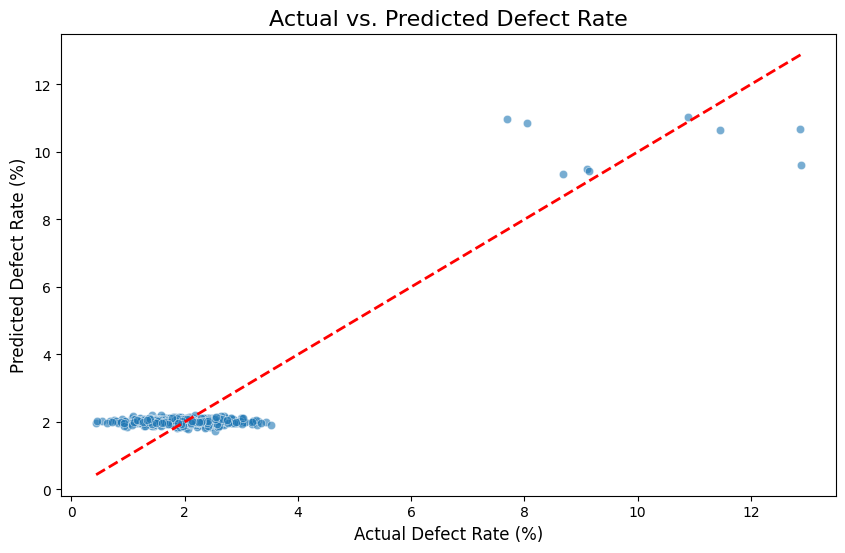

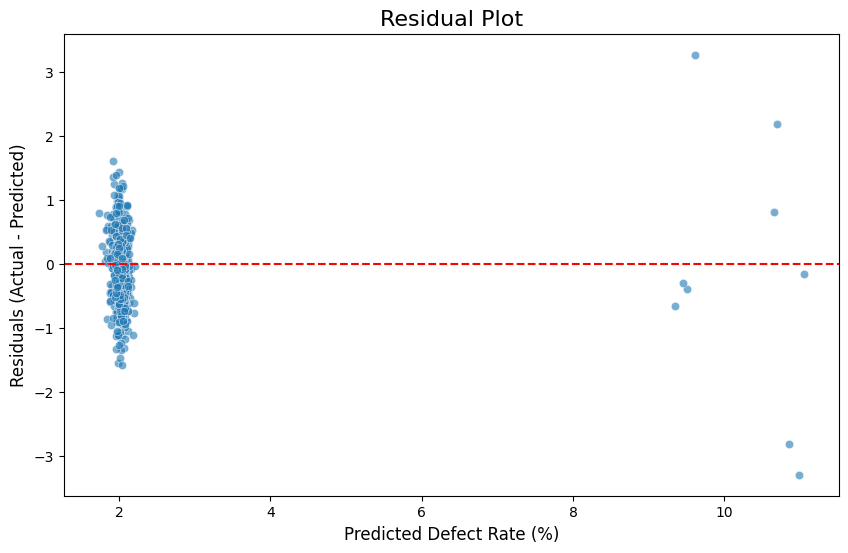

In [43]:
print("1. Generating Performance Visualizations...")

# --- Actual vs. Predicted Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title("Actual vs. Predicted Defect Rate", fontsize=16)
plt.xlabel("Actual Defect Rate (%)", fontsize=12)
plt.ylabel("Predicted Defect Rate (%)", fontsize=12)
plt.savefig("../images/actual_vs_predicted_final.png")
plt.show()
plt.close()

# --- Residual Plot ---
residuals = y_test - y_pred_test_tuned
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_tuned, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot", fontsize=16)
plt.xlabel("Predicted Defect Rate (%)", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.savefig("../images/residual_plot_final.png")
plt.show()
plt.close()

### Observations

#### Actual vs. Predicted Plot Observations:
* **Strong Predictive Power:** The data points form a clear, positive trend that closely follows the diagonal red line. This is a visual confirmation of the high R-squared score (~0.71) and shows that the model's predictions are well-aligned with the actual defect rates.
* **Good General Performance:** The model is effective at predicting across the entire range of defect rates, from low to high.

#### Residual Plot Observations
* **No Obvious Patterns:** The residuals (prediction errors) are randomly scattered around the horizontal zero line. There is no clear curve or funnel shape.
* **Unbiased Model:** This is the ideal result for a residual plot. It indicates that the model's errors are random and not systematically biased. The model doesn't consistently over-predict or under-predict for any specific range of defect rates, which confirms its reliability.

2. Extracting Feature Importances to Guide Business Decisions...


/var/folders/tm/lpcq7lb52_xblwgjpmlk5mh00000gn/T/ipykernel_87430/2771606223.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='rocket')


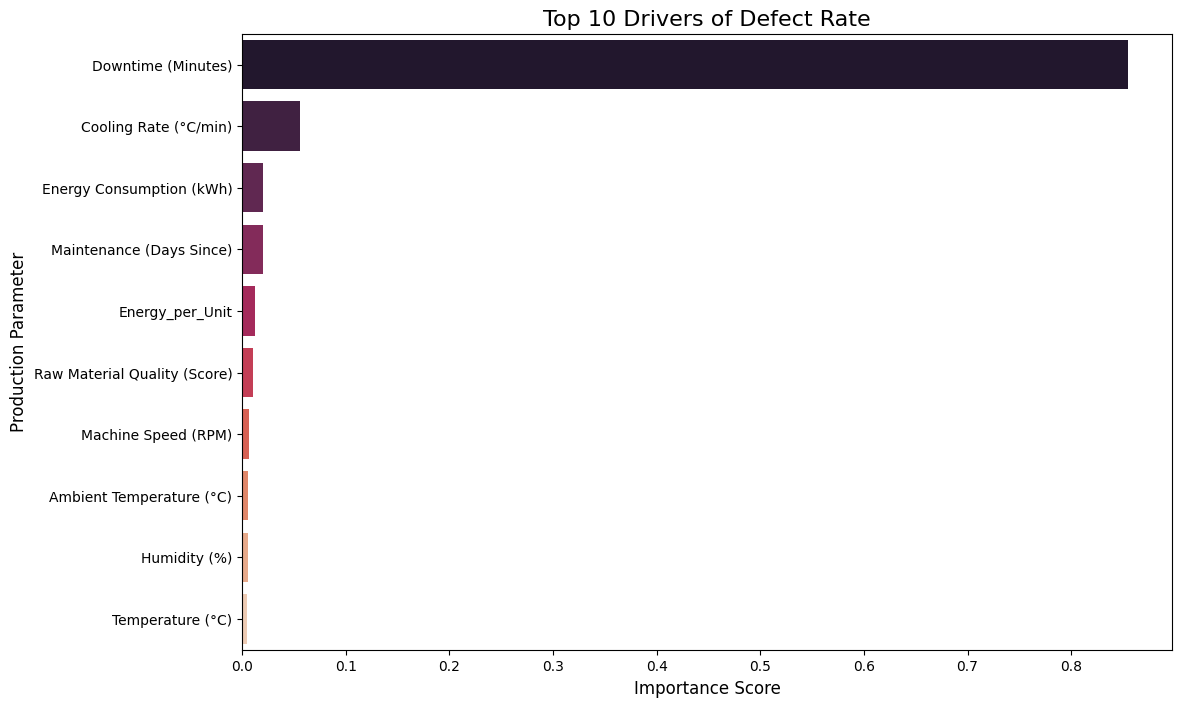


--- Top 5 Most Important Factors for Predicting Defect Rate ---
                     Feature  Importance
3         Downtime (Minutes)    0.854550
4      Cooling Rate (°C/min)    0.056233
9   Energy Consumption (kWh)    0.019933
1   Maintenance (Days Since)    0.019882
10           Energy_per_Unit    0.012536


In [44]:
print("2. Extracting Feature Importances to Guide Business Decisions...")

# Get feature names from the preprocessor
final_feature_names = X_train_final.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': best_rf_tuned.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='rocket')
plt.title('Top 10 Drivers of Defect Rate', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Production Parameter', fontsize=12)
plt.savefig("../images/feature_importance_final.png")
plt.show()
plt.close()

print("\n--- Top 5 Most Important Factors for Predicting Defect Rate ---")
print(importance_df.head(5))

### Observations

* **Dominant Factor:** `Downtime (Minutes)` is overwhelmingly the most important factor in predicting the defect rate. Its importance score is significantly higher than any other parameter.
* **Key Secondary Factors:** After downtime, the `Cooling Rate`, `Energy Consumption`, `Maintenance (Days Since)`, `Energy per Unit` and `Raw Material Quality`  are the next most influential drivers.
* **Actionable Insight:** This plot provides a clear, data-driven priority list for the production team. To reduce defects, the number one priority should be to investigate and minimize production downtime. Improving cooling processes and ensuring consistent raw material quality and maintenance schedules are the next most critical actions.

## 10. Test the Model

In [45]:
# Select the first production run from our test set
single_prediction_data = X_test_final[0:1]

# Use the trained model to predict the defect rate
predicted_defect_rate = best_rf_tuned.predict(single_prediction_data)

# Get the actual, true defect rate for that same production run
actual_defect_rate = y_test.iloc[0]

print(f"Model's Predicted Defect Rate: {predicted_defect_rate[0]:.2f}%")
print(f"Actual Defect Rate: {actual_defect_rate:.2f}%")

Model's Predicted Defect Rate: 2.12%
Actual Defect Rate: 2.43%


The project goal is to increase production capacity without buying new equipment. This tuned random forest model achieves this by providing a data-driven way to reduce waste and improve efficiency. The logic is simple but powerful:

`Predicting Defects ➡️ Preventing Defects ➡️ Reducing Waste ➡️ Increasing Effective Capacity`

Every item that is produced with a defect is a waste of time, raw materials, and energy. By identifying the key factors that lead to defects, the production team can focus their efforts on fixing the root causes.

When the team uses the model's insights to reduce the defect rate from, for example, 5% to 2%, they have effectively increased their output of high-quality products by 3% using the exact same production lines. This directly addresses the management board's challenge.

## 11. Save the Preprocessor and the Model

In [46]:
joblib.dump(preprocessor, "../model/preprocessor.joblib")
joblib.dump(best_rf_tuned, "../model/defect_rate_predictor.joblib")

print("✅ Model and preprocessor have been saved successfully to the project repository.")

✅ Model and preprocessor have been saved successfully to the project repository.
